In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error

/home/vt337/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
proj_dir = Path("..") / "Data/r77-mini-data-fortnight"
print(proj_dir.joinpath("input"))

data_dir = proj_dir
input_dir = data_dir.joinpath("input")
fixed_input_dir = input_dir.joinpath("fixed")
temporal_input_dir = input_dir.joinpath("temporal")
target_dir = data_dir.joinpath("target")
fixed_target_dir = target_dir.joinpath("fixed")
temporal_target_dir = target_dir.joinpath("temporal")

../Data/r77-mini-data-fortnight/input


In [3]:
files = list(temporal_target_dir.iterdir())


index_dir = Path("..")/"Index"
files_index = list(index_dir.iterdir())
indices = np.load(files_index[0]).squeeze()

#First hour of data
index = indices[0]
tt = np.load(files[index]).squeeze()
tt.shape

(144, 70, 100, 3)

In [4]:
files_ti = list(temporal_input_dir.iterdir())

In [5]:
#all diff data
data = []

for j in range(360):
    index = indices[j]

    tt = np.load(files[index]).squeeze()
    tt = np.transpose(tt, (0, 2, 3, 1))[:, :, :, :64]  #shape: (144, 100, 3, 64)

    ti = np.load(files_ti[index]).squeeze()
    ti = np.transpose(ti, (0, 2, 1))[:, :, :64]  #shape: (144, 3, 64)

    #ensure ti has the same second dimension as tt
    ti_expanded = np.repeat(ti[:, None, :, :], tt.shape[1], axis=1)  #shape: (144, 100, 3, 64)

    #calculate diff and reshape
    diff_data = tt - ti_expanded  #shape: (144, 100, 3, 64)
    reshaped_tt = diff_data.reshape(-1, 3, 64)  #shape: (14400, 3, 64)

    data.append(reshaped_tt)


data = np.concatenate(data).reshape(-1, 3, 64)
data.shape

(5184000, 3, 64)

In [6]:
def normalise(vector):
    min_val = np.min(vector)
    max_val = np.max(vector)
    normalised_vector = (vector - min_val) / (max_val - min_val)
    return normalised_vector, min_val, max_val

In [7]:
training_data = normalise(data)[0]
min_val = normalise(data)[1]
max_val = normalise(data)[2]

In [65]:
num_steps = {
    1000: 'Sample_diffs_0',
    10000: 'Sample_diffs_1',
    100000: 'Sample_diffs_4'
}

j = 100000


sample_diff_dir = Path(num_steps[j])
files_sample_diff = list(sample_diff_dir.iterdir())

sample_diffs = np.load(files_sample_diff[0]).squeeze()
sample_diffs.shape

(10000, 3, 64)

In [62]:
def denormalise(normalised_vector, min_val, max_val):
    original_vector = normalised_vector * (max_val - min_val) + min_val
    return original_vector

samples = denormalise(sample_diffs, min_val, max_val)

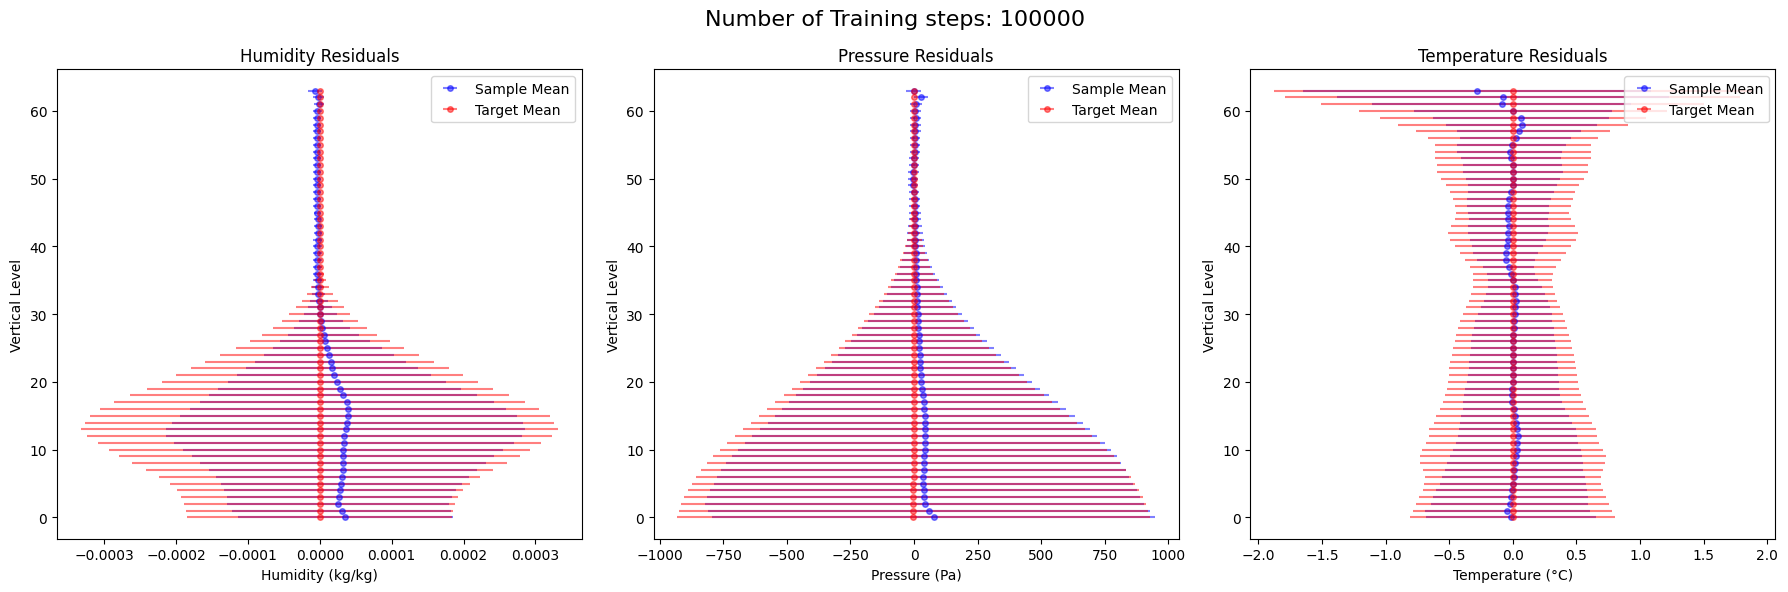

In [63]:
sample_humidity = samples[:, 0, :]* 0.025
sample_pressure = samples[:, 1, :]* 106000
sample_temperature = samples[:, 2, :]*180

target_humidity = data[:,0,:]* 0.025
target_pressure = data[:,1,:]* 106000 
target_temperature = data[:,2,:]*180 

#humid
target_mean_1h = np.mean(target_humidity, axis= 0)
sample_mean_1h = np.mean(sample_humidity, axis=0)
target_variance_1h= np.var(target_humidity, axis= 0)
sample_variance_1h = np.var(sample_humidity, axis=0)

#press
target_mean_1p = np.mean(target_pressure, axis= 0)
sample_mean_1p = np.mean(sample_pressure, axis=0)
target_variance_1p= np.var(target_pressure, axis= 0)
sample_variance_1p = np.var(sample_pressure, axis=0)

#temp
target_mean_1t = np.mean(target_temperature, axis= 0)
sample_mean_1t = np.mean(sample_temperature, axis=0)
target_variance_1t= np.var(target_temperature, axis= 0)
sample_variance_1t = np.var(sample_temperature, axis=0)



fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].errorbar(sample_mean_1h, np.arange(64), xerr=np.sqrt(sample_variance_1h), fmt='o', label='Sample Mean', markersize=4, color='blue', ecolor='blue', alpha=0.5)
axs[0].errorbar(target_mean_1h, np.arange(64), xerr=np.sqrt(target_variance_1h), fmt='o', label='Target Mean', markersize=4, color='red', ecolor='red', alpha=0.5)
axs[0].set_title('Humidity Residuals')
axs[0].set_xlabel('Humidity (kg/kg)')
axs[0].set_ylabel('Vertical Level')
axs[0].legend()

axs[1].errorbar(sample_mean_1p, np.arange(64), xerr=np.sqrt(sample_variance_1p), fmt='o', label='Sample Mean', markersize=4, color='blue', ecolor='blue', alpha=0.5)
axs[1].errorbar(target_mean_1p, np.arange(64), xerr=np.sqrt(target_variance_1p), fmt='o', label='Target Mean', markersize=4, color='red', ecolor='red', alpha=0.5)
axs[1].set_title('Pressure Residuals')
axs[1].set_xlabel('Pressure (Pa)')
axs[1].set_ylabel('Vertical Level')
axs[1].legend()


axs[2].errorbar(sample_mean_1t, np.arange(64), xerr=np.sqrt(sample_variance_1t), fmt='o', label='Sample Mean', markersize=4, color='blue', ecolor='blue', alpha=0.5)
axs[2].errorbar(target_mean_1t, np.arange(64), xerr=np.sqrt(target_variance_1t), fmt='o', label='Target Mean', markersize=4, color='red', ecolor='red', alpha=0.5)
axs[2].set_title('Temperature Residuals')
axs[2].set_xlabel('Temperature (\u00B0C)')
axs[2].set_ylabel('Vertical Level')
axs[2].legend()

fig.suptitle(f'Number of Training steps: {j}', fontsize = 16)
plt.tight_layout()


plt.show()




In [64]:
mse_hum = mean_squared_error(np.sqrt(target_variance_1h), np.sqrt(sample_variance_1h))
mse_pres = mean_squared_error(np.sqrt(target_variance_1p), np.sqrt(sample_variance_1p))
mse_temp = mean_squared_error(np.sqrt(target_variance_1t), np.sqrt(sample_variance_1t))


print(f'Mean squared error between target variances and sample variances in humidity: {mse_hum} kg/kg')
print(f'Mean squared error between target variances and sample variances in pressure: {mse_pres} Pa')
print(f'Mean squared error between target variances and sample variances in temperature: {mse_temp}(\u00B0C)')


Mean squared error between target variances and sample variances in humidity: 1.6899337484943544e-09 kg/kg
Mean squared error between target variances and sample variances in pressure: 499.46209716796875 Pa
Mean squared error between target variances and sample variances in temperature: 0.04152790457010269(°C)


In [56]:
mse_hum = mean_squared_error(np.sqrt(target_variance_1h), np.sqrt(sample_variance_1h))
mse_pres = mean_squared_error(np.sqrt(target_variance_1p), np.sqrt(sample_variance_1p))
mse_temp = mean_squared_error(np.sqrt(target_variance_1t), np.sqrt(sample_variance_1t))


print(f'Mean squared error between target variances and sample variances in humidity: {mse_hum} kg/kg')
print(f'Mean squared error between target variances and sample variances in pressure: {mse_pres} Pa')
print(f'Mean squared error between target variances and sample variances in temperature: {mse_temp}(\u00B0C)')


Mean squared error between target variances and sample variances in humidity: 8.772184090233281e-10 kg/kg
Mean squared error between target variances and sample variances in pressure: 206.0884246826172 Pa
Mean squared error between target variances and sample variances in temperature: 0.04221527278423309(°C)
